# Chapter 16 制約付き最小二乗法

## 16.1 制約付き最小二乗法

この章の例は，後で説明する関数`cls_solve`を用いて制約付き最小二乗問題を解く．

### 区分多項式

データに対して関数$\hat{f}: \boldsymbol{R} \to \boldsymbol{R}$をフィッティングする．ここで$x\le a$に対して$\hat{f} = p(x)$，$x > a$に対して$\hat{f}(x) = q(x)$とする．さらに$p(a)=q(a)$と$p'(a) = q'(a)$を満たすとする．つまり2つの多項式は分割点$a$で値も傾きも一致するとする．データ点は$x_1, \ldots, x_M \le a$と$x_{M+1}, \ldots, x_N > a$であり，対応する関数値は$y_1, \ldots, y_N$とする．以下の例では$a=0$，$p$と$q$は3次多項式，$N=2M=140$とする．以下のコードの結果は図16.1であり，本書の図16.1と似たものになる．ここでは＊＊ページの`vandermonde`関数を使っている．

In [3]:
using Plots, VMLS

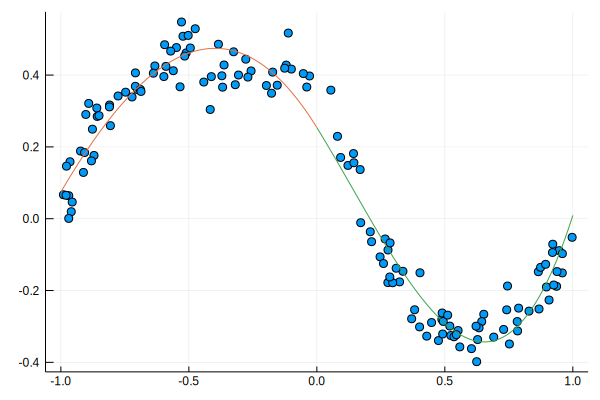

In [5]:
M = 70;
N = 2 * M;
xleft = rand(M) .- 1; 
xright = rand(M);
x = [xleft; xright];
y = x.^3 - x + 0.4 ./ (1 .+ 25*x.^2) + 0.05 * randn(N);
n = 4;
A = [ vandermonde(xleft,n) zeros(M,n);
      zeros(M,n) vandermonde(xright,n)];
b = y;
C = [1  zeros(1,n-1) -1  zeros(1,n-1);
     0  1  zeros(1,n-2)  0 -1  zeros(1,n-2)];
d = zeros(2);
theta = cls_solve(A, b, C, d);

# 分割点の左右に200点ずつ評価・プロット
Npl = 200;
xpl_left = linspace(-1, 0, Npl);
ypl_left = vandermonde(xpl_left, 4)*theta[1:n];
xpl_right = linspace(0, 1, Npl);
ypl_right = vandermonde(xpl_right, 4)*theta[n+1:end];
scatter(x,y, legend=false)
plot!(xpl_left, ypl_left)
plot!(xpl_right, ypl_right)


![図16.1](fig16-1.pdf)

図16.1 140点のデータに対して，2つの3次多項式を
続性の制約$p(0)=q(0)$と$p'(0) = q'(0)$の下で
最小二乗フィッティングした結果．



### 広告の予算

＊＊ページの広告の例の続きである．総予算の制限$\boldsymbol{1}^T s = 1284$を追加する．


In [6]:
R = [ 0.97  1.86  0.41;
      1.23  2.18  0.53;
      0.80  1.24  0.62;
      1.29  0.98  0.51;
      1.10  1.23  0.69;
      0.67  0.34  0.54;
      0.87  0.26  0.62;
      1.10  0.16  0.48;
      1.92  0.22  0.71;
      1.29  0.12  0.62];
m, n = size(R);

In [8]:
cls_solve(R, 1e3 * ones(m), ones(1, n), [1284])

3-element Array{Float64,1}:
 315.16818459234986
 109.86643348012271
 858.9653819275275 

### 最小ノルムとなる力の系列
摩擦のない面上で静止状態にある物体に1秒毎に10回加えて，位置が1，速度が0となるような最小の力の系列を求める．
（本書＊＊＊ページの例）．

In [9]:
A = eye(10);
b = zeros(10);
C = [ones(1, 10); (9.5:-1:0.5)']

2×10 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 9.5  8.5  7.5  6.5  5.5  4.5  3.5  2.5  1.5  0.5

In [10]:
d = [0, 1];

In [11]:
fln = cls_solve(A, b, C, d)

10-element Array{Float64,1}:
  0.05454545454545475  
  0.04242424242424237  
  0.030303030303030096 
  0.0181818181818182   
  0.0060606060606059305
 -0.006060606060606132 
 -0.01818181818181816  
 -0.030303030303030318 
 -0.04242424242424239  
 -0.05454545454545448  

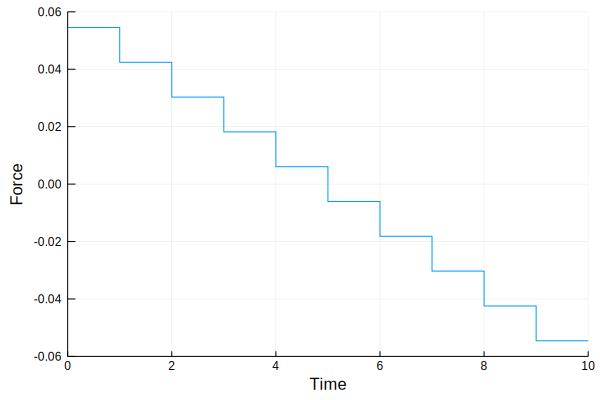

In [35]:
# 翻訳追加
plot(0:10, vcat(fln, fln[end]), xlabel="Time", ylabel="Force", linetype=:steppost, legend=false)
plot!(xlims = (0, 10))
plot!(ylims = (-0.06, 0.06))

## 16.2 解

関数`cls_solve_kkt`を実装しよう．これはKKT方程式を作成し，解いて，制約付き最小二乗問題の解を求めるものである．同じ$A$と$C$を持つ複数の問題を同時に解くことができるように，引数は`b`と`d`が行列でも動作するようにしている．

In [36]:
function cls_solve_kkt(A,b,C,d)
m, n = size(A)
p, n = size(C)
G = A' * A # グラム行列
KKT = [2*G C'; C zeros(p,p)] # KKT行列
xzhat = KKT \ [2*A'*b; d]
return xzhat[1:n, :]
end;

A = randn(10, 5); 
b = randn(10);
C = randn(2, 5);
d = randn(2);
x = cls_solve_kkt(A, b, C, d);
C * x - d # 残差が小さいかどうかをチェック

2×1 Array{Float64,2}:
 -1.1102230246251565e-16
 -2.7755575615628914e-17

## 16.3 制約付き最小二乗問題を解く

### QR分解による解法

本書のアルゴリズム16.1を実装し，上のKKT方程式を解く方法と比較する．


In [38]:
function cls_solve(A,b,C,d)
m, n = size(A)
p, n = size(C)
Q, R = qr([A; C])
Q = Matrix(Q)
Q1 = Q[1:m,:]
Q2 = Q[m+1:m+p,:]
Qtil, Rtil = qr(Q2')
Qtil = Matrix(Qtil)
w = Rtil \ (2 * Qtil' * Q1' * b - 2 * (Rtil' \ d))
return xhat = R \ (Q1' * b - Q2' * w / 2)
end

ErrorException: error in method definition: function VMLS.cls_solve must be explicitly imported to be extended

In [41]:
using LinearAlgebra

In [42]:
# KKT方程式を解く方法をチェック
m = 10;
n = 5;
p = 2;
A = randn(m, n);
b = randn(m);
C = randn(p, n);
d = randn(p);
xKKT = cls_solve_kkt(A, b, C, d);
xQR = cls_solve(A, b, C, d);
norm(xKKT - xQR)

5.768888059150692e-16

関数`cls_solve`は`VMLS`パッケージに含まれている．


### スパースな制約付き最小二乗問題

本書の式(16.11)の連立方程式の解法と，上記の制約付き最小二乗法の解法を比較しよう．これは，$A$と$C$がスパースなら連立方程式はスパースになる（以下のコードは2つの解法が一致するかどうかだけをチェックしていて，スパース性は使っていない．最初の`cls_solve`とは違い，`b`と`d`はベクトルであること仮定している）．

In [43]:
function cls_solve_sparse(A, b, C, d)
m, n = size(A)
p, n = size(C)
bigA = [ zeros(n,n) A' C';
         A -I/2 zeros(m,p) ;
         C zeros(p,m) zeros(p,p) ]
xyzhat = bigA \ [zeros(n) ; b ; d]
return xhat = xyzhat[1:n]
end

cls_solve_sparse (generic function with 1 method)

In [44]:
m = 100;
n = 50;
p = 10;
A = randn(m, n);
b = randn(m);
C = randn(p, n);
d = randn(p);
x1 = cls_solve(A, b, C, d);
x2 = cls_solve_sparse(A, b, C, d);
norm(x1 - x2)

9.6310410495185e-15

### 最小ノルム問題を解く

Juliaで劣決定の連立方程式$Cx=d$の最小ノルム解$\hat{x}$を求めるにはバックスラッシュ演算子を使う．つまりバックスラッシュ演算子はオーバーロードされており，係数行列が正方である場合には連立方程式を解き，係数行列が縦長の場合には最小二乗解を求め，係数行列が横長の場合には最小ノルム会を求める．

複数の解法で最小ノルム問題を解き，解が一致していることを確かめよう．


In [45]:
C = randn(p, n);
d = randn(p);

x1 = C \ d; # バックスラッシュを用いて解く
x2 = cls_solve(eye(n), zeros(n), C, d); # cls_solveを用いて解く．これはKKT方程式を使う．
x3 = pinv(C) * d; # 擬似逆行列を用いて解く

In [46]:
norm(x1 - x2)

9.39405218942815e-16

In [47]:
norm(x2 - x3)

1.1535415469319084e-15